# 1.微调数据集的处理

## 1.1 将单个fasta转化为单个pickle文件（已过时）

In [7]:
from Bio import SeqIO
import pickle

family_list = ['PF16754']

def fasta_to_pickle(fasta_file, pickle_file, family_name):
    data = {}
    for count, record in enumerate(SeqIO.parse(fasta_file, "fasta")):
        sequences = {'other_taxa': [family_name], 'seq': str(record.seq)}
        data[count] = sequences
    
    with open(pickle_file, 'wb') as f:
        pickle.dump(data, f)

for _ in family_list:
    # 替换为你的FASTA文件路径和要保存的Pickle文件路径
    fasta_path = '../lysozyme_dataset/'+ _ + '.fasta'
    pickle_path = 'dataset/train_' + _ + '.p'

    fasta_to_pickle(fasta_path, pickle_path, _)

0 {'other_taxa': ['PF16754'], 'seq': 'MLEPKEGLLTFRAEGNNLAGSRYYSRKLHWPGVASKCNTYGSGVTFGRGYDMKHRSAGEIIADLTFAGIPLDEAKKIAGGAHKSHCAASEFVKNNKGSTIELTEHQQLRLFEKVYARYVKDSIRFYNKYKKQDSVSWDKIPPALKEVFVDMKYQGAMSREMVPVFGRNNKDYVIKLIRNNPDIMLHESARCRIPYIQRYVK'}
1 {'other_taxa': ['PF16754'], 'seq': 'MLEPKEGLLTFRAEGNNFRGSRYYSRKIHWPGNSPACGKNASGVTIGRGFDLGGRSEKEALSYLILAGIPTEKAIKISAGSKLTHCRADEFVKVNKDSIGEITESQQLRLFENVYRNYLYDAIRFYNKYKNSGSESWNKLDKKVKDVFVDMKYQGVLSKNMVKFFEKNNRFDVIYLIENDKYLMSYESSRGRLGYLKDKS'}
2 {'other_taxa': ['PF16754'], 'seq': 'MSPHPESHTYLTAADLADPNKRMPINPDRGCLGGGACAPGLKYLEDFTREYEGYTLLPYIPGVYLVEKDPDGVHQIPKPIKGLFLDQERKVVDWAVFDRNLHKIKHSGVTIDTGYDLGQHSEYDVRNAARAYIREKGALPAGMNLEDLIGRLRPFFARGPGKALEGRAAMEALVAKPEFALSDQEAEFLRDTHIFRDAPTVAGQYQEKQRNGVGNFYQLPAEVQTTIIDWTWAFGTKDDSDHTRAFWQHVYRGEWAQLRRELESNTLDVGPNRAYQSVDYVRRRRALGALLGKALDRGWPENGGAC'}
3 {'other_taxa': ['PF16754'], 'seq': 'MNRAITALAGPQSRSFMLLSIFAVALTDPTTASAFDCRKASTPTEKAICADPELKRKDNQLSRDYALFRQHFSKSGNYDCLVAEQKKRQFEWLKERDACGADKACIAAAYDKRQNQLDLFTRACFPMDSMRP

## 1.2 将多个fasta文件整合为一个pickle文件

In [2]:
from Bio import SeqIO
import pickle
import random

filter_min = 60
filter_max = 512


def random_dic(dicts):
    '''
    打乱字典顺序
    '''
    dict_key_ls = list(dicts.keys())
    random.shuffle(dict_key_ls)
    new_dict = {}
    for key in dict_key_ls:
        new_dict[key] = dicts.get(key)
    return new_dict

family_list = ['PF00959', 'PF01832', 'PF05838', 'PF06737','PF16754']
data = {}
pickle_path = 'dataset/train_data['+str(filter_min)+','+str(filter_max)+'].p'
seq_id = 0
for _ in family_list:
    # 替换为你的FASTA文件路径和要保存的Pickle文件路径
    fasta_path = "../dataset/filter_dataset/"+_+"_filter.fasta"
    for count, record in enumerate(SeqIO.parse(fasta_path, "fasta")):
        sequences = {'other_taxa': [_], 'seq': str(record.seq)}
        data[seq_id] = sequences
        seq_id += 1
print("所有家族fasta文件读取完成, 总共 ", len(data)," 条数据")
# 打乱数据
random_data = random_dic(data)

# 写入.p文件
with open(pickle_path, 'wb') as f:
    pickle.dump(random_data, f)

所有家族fasta文件读取完成, 总共  67070  条数据


## 1.3 将多个fasta文件合并为一个fasta文件

## 1.4 使用cd-hit对微调数据集进行聚类分析

In [ ]:
# 参数说明
# -i 输入文件，fasta格式的序列
# -o 输出文件路径和名字
# -c 相似性（clustering threshold），0.9表示相似性大于等于90%的为一类
# -n 两两序列进行序列比对时选择的 word size
# -d 0表示使用 fasta 标题中第一个空格前的字段作为序列名字
# -M 16000，16GB RAM
# -T 使用的线程数

# 参考执行代码：./cd-hit -i ../../dataset/lysozyme_dataset/PF00959.fasta -o ../output_file/PF00959_data_cluster80.fasta -c 0.8 -n 5 -T 4

## 1.5 筛选微调数据集

In [1]:
from Bio import SeqIO

# lengthdict = {'min_PF00959':151-30,'max_PF00959':151+30,
#                 'min_PF05838':152-38,'max_PF05838':152+38, 
#                 'min_PF01832':138-14,'max_PF01832':138+14,
#                 'min_PF06737':84-40,'max_PF06737':84+40,
#                 'min_PF16754':167-28,'max_PF16754':167+28}

lengthdict = {'min_PF00959':201-30,'max_PF00959':201+30,
                'min_PF05838':212-38,'max_PF05838':212+38, 
                'min_PF01832':389-14,'max_PF01832':389+14,
                'min_PF06737':84-40,'max_PF06737':84+40,
                'min_PF16754':167-28,'max_PF16754':167+28}
filter_min = 60
filter_max = 512


# 计算序列平均长度
def calculate_sequence_stats(records):
    lengths = [len(record.seq) for record in records]
    max_length = max(lengths)
    min_length = min(lengths)
    avg_length = sum(lengths) / len(lengths)
    return max_length, min_length, avg_length

# 输出数据集的信息
def print_dataset_info(fasta_file):
    records = list(SeqIO.parse(fasta_file, 'fasta'))
    max_length, min_length, avg_length = calculate_sequence_stats(records)

    print(f"Maximum Sequence Length: {max_length}，Minimum Sequence Length: {min_length}，Average Sequence Length: {avg_length:.2f}")
    print(f"total dataset number:{len(records)}")

def filter_sequences(input_file, output_file, min_length, max_length):
    '''
    根据长度区间，筛选掉不需要的序列
    '''
    selected_records = []

    for record in SeqIO.parse(input_file, 'fasta'):
        sequence_length = len(record.seq)
        if min_length <= sequence_length <= max_length:
            selected_records.append(record)

    with open(output_file, 'w') as output_handle:
        SeqIO.write(selected_records, output_handle, 'fasta')

family_list = ['PF00959','PF01832', 'PF05838', 'PF06737','PF16754']

for fn in family_list:
    min_length = "min_" + fn
    max_length = "max_" + fn
    input_file = "../dataset/lysozyme_dataset/"+fn+".fasta"
    print("过滤前，"+fn+"家族的信息如下：")
    print_dataset_info(input_file)

    output_file = "../dataset/filter_dataset/"+fn+"_filter.fasta"
    # filter_sequences(input_file, output_file, lengthdict[min_length], lengthdict[max_length])
    filter_sequences(input_file, output_file, filter_min, filter_max)
    print("过滤后，"+fn+"家族的信息如下：")
    print_dataset_info(output_file)    

过滤前，PF00959家族的信息如下：
Maximum Sequence Length: 4673，Minimum Sequence Length: 39，Average Sequence Length: 201.51
total dataset number:19584
过滤后，PF00959家族的信息如下：
Maximum Sequence Length: 512，Minimum Sequence Length: 60，Average Sequence Length: 181.16
total dataset number:18623
过滤前，PF01832家族的信息如下：
Maximum Sequence Length: 5577，Minimum Sequence Length: 37，Average Sequence Length: 389.85
total dataset number:33741
过滤后，PF01832家族的信息如下：
Maximum Sequence Length: 512，Minimum Sequence Length: 61，Average Sequence Length: 305.62
total dataset number:27808
过滤前，PF05838家族的信息如下：
Maximum Sequence Length: 5819，Minimum Sequence Length: 29，Average Sequence Length: 212.00
total dataset number:7156
过滤后，PF05838家族的信息如下：
Maximum Sequence Length: 511，Minimum Sequence Length: 60，Average Sequence Length: 199.83
total dataset number:6954
过滤前，PF06737家族的信息如下：
Maximum Sequence Length: 2403，Minimum Sequence Length: 31，Average Sequence Length: 307.34
total dataset number:13744
过滤后，PF06737家族的信息如下：
Maximum Sequence Length: 5

## 1.6 fasta文件家族序列长度统计

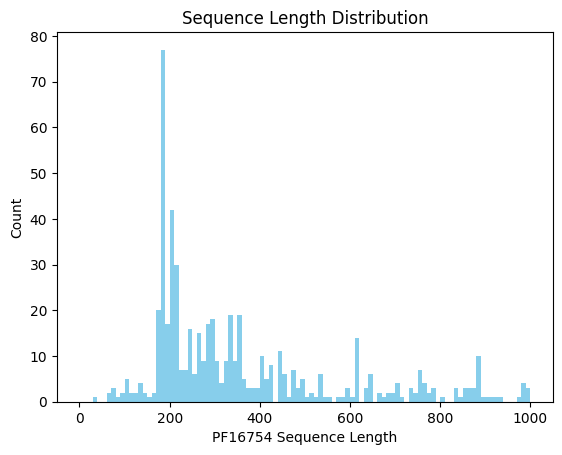

In [9]:
from Bio import SeqIO
import matplotlib.pyplot as plt

family_name = "PF16754"

def read_fasta_file(file_path):
    sequence_lengths = []
    with open(file_path, 'r') as file:
        for record in SeqIO.parse(file, 'fasta'):
            sequence_lengths.append(len(record.seq))
    return sequence_lengths

def plot_length_distribution(sequences):
    plt.hist(sequences, bins=100, range=(0, 1000), color='skyblue')
    plt.xlabel(family_name+ ' Sequence Length')
    plt.ylabel('Count')
    plt.title('Sequence Length Distribution')
    plt.show()

# 读取FASTA文件中的序列长度
fasta_file = '../dataset/lysozyme_dataset/'+family_name+'.fasta'
# fasta_file = '../dataset/lysozyme_dataset/EC_number_dataset/'+family_name+'.fasta'
sequence_lengths = read_fasta_file(fasta_file)

# 绘制长度统计图
plot_length_distribution(sequence_lengths)

# 2.将蛋白质pickle文件编码

## 2.1transformProtein类(outdated)

## 2.2 查看pickle文件

In [1]:
import pickle

pickle_path = 'mapping_files/aa_to_ctrl_idx.p'
# 以二进制读模式打开.p文件
with open(pickle_path, 'rb') as f:
    # 从文件中读取数据
    data = pickle.load(f)


# 输出读取到的数据信息
print("该文件的字典大小为："+str(len(data)))
# 查看前5个元素
count = 0
for key, value in data.items():
    print("键:", key, " 值:", value)
    count += 1
    # if count == 5:
    #     break
# print(max(data.values()))

该文件的字典大小为：25
键: A  值: 129381
键: B  值: 129382
键: C  值: 129383
键: D  值: 129384
键: E  值: 129385
键: F  值: 129386
键: G  值: 129387
键: H  值: 129388
键: I  值: 129389
键: K  值: 129390
键: L  值: 129391
键: M  值: 129392
键: N  值: 129393
键: O  值: 129394
键: P  值: 129395
键: Q  值: 129396
键: R  值: 129397
键: S  值: 129398
键: T  值: 129399
键: U  值: 129400
键: V  值: 129401
键: W  值: 129402
键: X  值: 129403
键: Y  值: 129404
键: Z  值: 129405


## 2.3 创建 家族标签——编码 之间的pickle文件

In [1]:
import pickle

data = {'PF00959': 0, 'PF01832': 1, 'PF05838': 2, 'PF06737': 3,'PF16754': 4, 'STOP': 5, 'PAD': 129406}

# 文件路径
file_path = 'mapping_files/familyname_to_code.p'

# 创建.p文件
with open(file_path, 'wb') as file:
    pickle.dump(data, file)